<a href="https://colab.research.google.com/github/anastasiarenata1/deeplearning/blob/main/LNN_with_Numpy_and_Softmax_Classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Problem 4 - Regression

Classification data from 2011 Million Song Challenge dataset to predict music year

* Explore three shallow (linear) neural network models with different activation functions for this task.
* Evaluate the model by rounding the output of your linear neural network and compute the mean squared error


###1. Load and explore the data

In [2]:
!wget https://archive.ics.uci.edu/ml/machine-learning-databases/00203/YearPredictionMSD.txt.zip
!unzip YearPredictionMSD.txt.zip

--2023-03-02 04:33:15--  https://archive.ics.uci.edu/ml/machine-learning-databases/00203/YearPredictionMSD.txt.zip
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 211011981 (201M) [application/x-httpd-php]
Saving to: ‘YearPredictionMSD.txt.zip’

YearPredictionMSD.t 100%[===================>] 201.24M  17.3MB/s    in 13s     

2023-03-02 04:33:29 (15.2 MB/s) - ‘YearPredictionMSD.txt.zip’ saved [211011981/211011981]

Archive:  YearPredictionMSD.txt.zip
  inflating: YearPredictionMSD.txt   


In [3]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

In [4]:
colnames = ['target'] + ['timbre_avg_' + str(i) for i in range(1, 13)] + ['timbre_covar_' + str(i) for i in range(1, 79)]
df = pd.read_csv('YearPredictionMSD.txt', header=None, names=colnames)
df.head(5)

,target,timbre_avg_1,timbre_avg_2,timbre_avg_3,timbre_avg_4,timbre_avg_5,timbre_avg_6,timbre_avg_7,timbre_avg_8,timbre_avg_9,...,timbre_covar_69,timbre_covar_70,timbre_covar_71,timbre_covar_72,timbre_covar_73,timbre_covar_74,timbre_covar_75,timbre_covar_76,timbre_covar_77,timbre_covar_78
0,2001,49.94357,21.47114,73.07750,8.74861,-17.40628,-13.09905,-25.01202,-12.23257,7.83089,...,13.01620,-54.40548,58.99367,15.37344,1.11144,-23.08793,68.40795,-1.82223,-27.46348,2.26327
1,2001,48.73215,18.42930,70.32679,12.94636,-10.32437,-24.83777,8.76630,-0.92019,18.76548,...,5.66812,-19.68073,33.04964,42.87836,-9.90378,-32.22788,70.49388,12.04941,58.43453,26.92061
2,2001,50.95714,31.85602,55.81851,13.41693,-6.57898,-18.54940,-3.27872,-2.35035,16.07017,...,3.03800,26.05866,-50.92779,10.93792,-0.07568,43.20130,-115.00698,-0.05859,39.67068,-0.66345
3,2001,48.24750,-1.89837,36.29772,2.58776,0.97170,-26.21683,5.05097,-10.34124,3.55005,...,34.57337,-171.70734,-16.96705,-46.67617,-12.51516,82.58061,-72.08993,9.90558,199.62971,18.85382
4,2001,50.97020,42.20998,67.09964,8.46791,-15.85279,-16.81409,-12.48207,-9.37636,12.63699,...,9.92661,-55.95724,64.92712,-17.72522,-1.49237,-7.50035,51.76631,7.88713,55.66926,28.74903


Write a function to load the dataset, e.g.,
`trainYears, trainFeat, testYears, testFeat = loadMusicData(fname, addBias)`

In [5]:
def loadMusicData(data, addBias=True):
  train_df = data[:463714]
  test_df = data[463714:]
  train_y = train_df['target'].values
  train_x = train_df.iloc[:,1:].values
  test_y = test_df['target'].values
  test_x = test_df.iloc[:,1:].values
  if addBias:
    train_x = np.hstack((train_x, np.ones((train_x.shape[0],1))))
    test_x = np.hstack((test_x, np.ones((test_x.shape[0],1))))
  return train_y, train_x, test_y, test_x

Write a function `mse = musicMSE(pred, gt)` where the inputs are the predicted year and the “ground truth” year from the dataset. The function computes the mean squared error(MSE) by rounding pred before computing the MSE.

In [6]:
from sklearn.metrics import mean_squared_error
def musicMSE(pred, gt):
  pred = np.round(pred)
  mse= mean_squared_error(pred, gt)
  return mse

Load the dataset and discuss its properties. 
1. What is the range of the variables? From 90 attributes, range of variables for timbre average is tighter than range of variables for timbre covariance. However, within each category itself, some attributes have wider range compared to others, in which we don't have further documentation to explain this event.
2. How might you normalize them? Normalization can help to ensure that each variables contribute equally to the model. Since range of variables varies significantly accross 90 attributes, I will normalize the data using standardization technique (0 mean and unit std deviation for each attribute) where we can help to preserve importance of variables.
3. What years are represented in the dataset? The dataset covers song released from 1922 to 2011 (90 years) with most common year of 2007.
4. What will the test mean squared error (MSE) be if your classifier always outputs the most common year in the dataset? 190.08

In [7]:
# Range of variables
var_ranges = np.ptp(df.iloc[:, 1:].values, axis=0)
for i, var_range in enumerate(var_ranges):
    print("Variable {}: range = {:.0f}".format(i+1, var_range))

Variable 1: range = 60
Variable 2: range = 721
Variable 3: range = 624
Variable 4: range = 490
Variable 5: range = 444
Variable 6: range = 248
Variable 7: range = 361
Variable 8: range = 199
Variable 9: range = 273
Variable 10: range = 102
Variable 11: range = 158
Variable 12: range = 182
Variable 13: range = 550
Variable 14: range = 65727
Variable 15: range = 36796
Variable 16: range = 31832
Variable 17: range = 19854
Variable 18: range = 16826
Variable 19: range = 11882
Variable 20: range = 9564
Variable 21: range = 9610
Variable 22: range = 3707
Variable 23: range = 6731
Variable 24: range = 9808
Variable 25: range = 4871
Variable 26: range = 37870
Variable 27: range = 26522
Variable 28: range = 7735
Variable 29: range = 6635
Variable 30: range = 6669
Variable 31: range = 6153
Variable 32: range = 3471
Variable 33: range = 4567
Variable 34: range = 3921
Variable 35: range = 2803
Variable 36: range = 4208
Variable 37: range = 22597
Variable 38: range = 18155
Variable 39: range = 1586

In [8]:
#Normalize data using standardization
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

def loadMusicData2(data, addBias=True):
  train_df = data[:463714]
  test_df = data[463714:]
  train_y = train_df['target'].values
  train_x = train_df.iloc[:,1:].values
  test_y = test_df['target'].values
  test_x = test_df.iloc[:,1:].values
  train_x= scaler.fit_transform(train_x)
  test_x= scaler.fit_transform(test_x)

  if addBias:
    train_x = np.hstack((train_x, np.ones((train_x.shape[0],1))))
    test_x = np.hstack((test_x, np.ones((test_x.shape[0],1))))
  

  return train_y, train_x, test_y, test_x

In [9]:
#Years represented
print('Min years presented: ', np.min(df['target']))
print('Max years presented: ', np.max(df['target']))
print('Median years presented: ', np.median(df['target']))

from statistics import mode
print('Most common year:', mode(df['target']))

Min years presented:  1922
Max years presented:  2011
Median years presented:  2002.0
Most common year: 2007


In [83]:
train_y, train_x, test_y, test_x = loadMusicData2(df, addBias=True)

In [11]:
#test MSE
musicMSE(torch.full((test_y.shape[0],), 2007), test_y)

190.08239236117836

##2. Classification
This problem could have been posed as a classification problem by treating each year as a category. What would be the problems with this approach? Support your argument by analyzing a bar chart with the year as the x-axis and the number of examples for that year as the y-axis.

As we can see from the chart, the distribution of train dataset is skewed to the left where majority of the data coming from the later years. If we treat this problem as a classification problem, the model will be biased and will be more likely to predict later years. Furthermore, classification means that the predicted data will be categorical values instead of continuous which can result in loss of information as repercussion. 

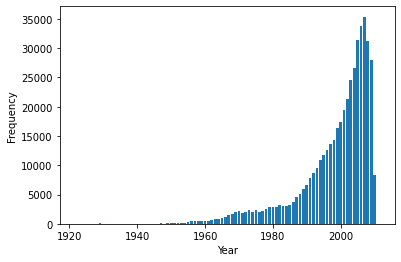

In [12]:
#plot year frequency from train dataset
import matplotlib.pyplot as plt
train_df = df[:463714]
year_counts = train_df.iloc[:, 0].value_counts()
plt.bar(year_counts.index, year_counts.values)
plt.xlabel("Year")
plt.ylabel("Frequency")
plt.show()

##3. Ridge regression

* Implement stochastic gradient descent with mini-batches to minimize the loss and evaluate the train and test MSE.
* Tune the learning rate and weight decay factor. 
* Show the train and test loss as a function of epochs, where the number of epochs should be chosen to ensure the train loss is minimized.

In [109]:
def mini_batch_gradient_descent(X_train, y_train, X_test, y_test, batch_size=32, num_epochs=100, learning_rate=0.01, weight_decay_factor=0, loss_type='L2', weight_decay_form='none', momentum=False, momentum_factor=0.9):
    num_features = X_train.shape[1]
    num_batches = int(np.ceil(len(X_train) / batch_size))
    weight = np.random.normal(size=num_features)
    m = np.zeros_like(weight)
    train_losses = []
    test_losses = []

    def forward(X, w):
        return np.dot(X, w)

    def backward(X, error):
        return np.dot(X.T, error)

    def compute_gradient(X, y, y_pred, loss_type, w):
      error = None
      if loss_type == "L2":
          error = 2*(y_pred - y)
      elif loss_type == "count":
          error = np.round(y_pred) - np.round(y)
      elif loss_type == "cross-entropy":
          error = y_pred - y
      elif loss_type == 'L1':
          error = np.sign(y_pred - y)
      gradient = backward(X, error)
      if weight_decay_form == 'L2':
          gradient += weight_decay_factor * w
      elif weight_decay_form == 'L1':
          gradient += weight_decay_factor * np.sign(w)
      return gradient, error

    def compute_loss(y, y_pred, loss_type):
        if loss_type == "L2":
            return np.mean(np.square(y - y_pred))
        elif loss_type == "count":
            return np.mean(np.abs(np.round(y) - np.round(y_pred)))
        elif loss_type == "cross-entropy":
            y_pred = np.clip(y_pred, 1e-15, 1 - 1e-15)  # clip predictions
            return -np.mean(y * np.log(y_pred) + (1 - y) * np.log(1 - y_pred))
        elif loss_type == 'L1':
            return np.mean(np.abs(y - y_pred))

    for epoch in range(num_epochs):
        # Shuffle the data
        perm = np.random.permutation(len(X_train))
        X_train = X_train[perm]
        y_train = y_train[perm]

        # Mini-batch gradient descent
        for i in range(num_batches):
            start_idx = i * batch_size
            end_idx = (i + 1) * batch_size
            X_batch = X_train[start_idx:end_idx]
            y_batch = y_train[start_idx:end_idx]

            y_pred = forward(X_batch, weight)
            gradient, error = compute_gradient(X_batch, y_batch, y_pred, loss_type, weight)

            if momentum:
              m = momentum_factor * m + (1 - momentum_factor) * gradient
              weight -= learning_rate * m
            else:
                weight -= learning_rate * gradient.reshape(weight.shape)

        # Compute train and test losses
        y_train_pred = forward(X_train, weight)
        train_loss = compute_loss(y_train, y_train_pred, loss_type)
        train_losses.append(train_loss)

        y_test_pred = forward(X_test, weight)
        test_loss = compute_loss(y_test, y_test_pred, loss_type)
        test_losses.append(test_loss)

        print("Epoch:", epoch+1, "/100, Train loss:", train_loss, "Test loss:", test_loss)

    return weight, train_losses, test_losses


Hyperparameter tuning
* Learning rate= 0.0001
* Weight decay factor= 0.000001
* Batch size=16
* Number epochs=100
* Loss type= L2
* Weight decay form= None
* No momentum



In [110]:
w_ridge, train_loss_ridge, test_loss_ridge = mini_batch_gradient_descent(train_x, train_y, test_x, test_y, batch_size=16, num_epochs=100, learning_rate=0.000001, weight_decay_factor=0.000001, loss_type='L2', weight_decay_form=None, momentum=False, momentum_factor=None)

Epoch: 1 /100, Train loss: 625031.7119610738 Test loss: 625203.0811098132
Epoch: 2 /100, Train loss: 97870.4163194665 Test loss: 97937.24304554866
Epoch: 3 /100, Train loss: 15392.919365339705 Test loss: 15419.069182976817
Epoch: 4 /100, Train loss: 2488.3059055079752 Test loss: 2498.031320338508
Epoch: 5 /100, Train loss: 468.1861523742782 Test loss: 471.5198856097959
Epoch: 6 /100, Train loss: 151.67055066751848 Test loss: 152.47556917553456
Epoch: 7 /100, Train loss: 101.75609316415725 Test loss: 101.54875612326255
Epoch: 8 /100, Train loss: 93.69772447775267 Test loss: 93.07710232353566
Epoch: 9 /100, Train loss: 92.25594079939825 Test loss: 91.53873515886673
Epoch: 10 /100, Train loss: 91.904368521772 Test loss: 91.13747164799591
Epoch: 11 /100, Train loss: 91.75992685818932 Test loss: 90.99228741314393
Epoch: 12 /100, Train loss: 91.65899165104233 Test loss: 90.84925917027796
Epoch: 13 /100, Train loss: 91.587272858718 Test loss: 90.77708813294805
Epoch: 14 /100, Train loss: 91.5

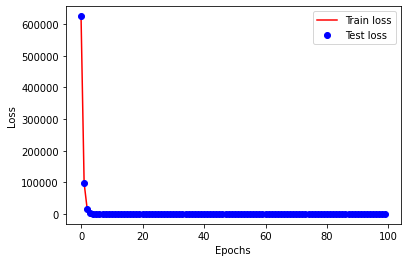

In [15]:
num_epochs=100
plt.plot(range(num_epochs), train_loss_ridge,'r', label="Train loss")
plt.plot(range(num_epochs), test_loss_ridge, 'bo',label="Test loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

Pseudoinverse

In [16]:
def compute_loss(X, y, weight, loss_type):
    if loss_type == 'L2':
        loss = np.mean((np.dot(X, weight) - y) ** 2)
    elif loss_type == 'count':
        loss = np.mean(np.abs(np.dot(X, weight) - y))
    elif loss_type == 'cross-entropy':
        exp_term = np.exp(np.dot(X, weight))
        loss = np.mean(np.log(1 + exp_term) - y * np.dot(X, weight))
    return loss

def pseudoinverse(train_x, train_y, test_x, test_y, alpha=0, loss_type='L2'):
    pseudoinv= np.dot(np.linalg.inv(train_x.T.dot(train_x) + alpha*np.eye(train_x.shape[1])), train_x.T)
    weight= np.dot(pseudoinv, train_y)
    train_y_predict= np.dot(train_x, weight)
    test_y_predict= np.dot(test_x, weight)

    train_loss= compute_loss(train_x, train_y, weight, loss_type=loss_type)
    test_loss= compute_loss(test_x, test_y,weight, loss_type=loss_type)
  
    print(f'Train loss: {train_loss:.4f}, Test loss: {test_loss:.4f}')
    
    return weight, train_loss, test_loss

In [17]:
weight_inverse, train_loss_inverse, test_loss_inverse = pseudoinverse(train_x, train_y, test_x, test_y, alpha=0, loss_type='L2')

Train loss: 91.2564, Test loss: 90.4911


##4. Implement L1 weight decay

Epoch: 1 /100, Train loss: 1536.0170531858057 Test loss: 1536.126899846275
Epoch: 2 /100, Train loss: 1072.4479731864324 Test loss: 1072.5578198469013
Epoch: 3 /100, Train loss: 608.8788931871475 Test loss: 608.9887398476164
Epoch: 4 /100, Train loss: 145.30981318786226 Test loss: 145.41965984833132
Epoch: 5 /100, Train loss: 6.5264703281596494 Test loss: 6.54889155776134
Epoch: 6 /100, Train loss: 6.53058675358964 Test loss: 6.541458864460236
Epoch: 7 /100, Train loss: 6.5328863174135225 Test loss: 6.543642522543737
Epoch: 8 /100, Train loss: 6.524030215931672 Test loss: 6.536205762485475
Epoch: 9 /100, Train loss: 6.537786488604928 Test loss: 6.563258804596527
Epoch: 10 /100, Train loss: 6.531281739970744 Test loss: 6.547503258074349
Epoch: 11 /100, Train loss: 6.534989070496271 Test loss: 6.554967066901637
Epoch: 12 /100, Train loss: 6.531095532992763 Test loss: 6.556480301049497
Epoch: 13 /100, Train loss: 6.524887764207581 Test loss: 6.535603956175979
Epoch: 14 /100, Train loss: 6

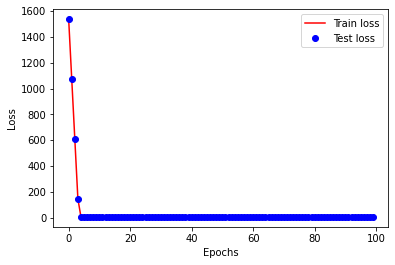

In [88]:
w_lasso, train_loss_lasso, test_loss_lasso = mini_batch_gradient_descent(train_x, train_y, test_x, test_y, batch_size=32, num_epochs=100, learning_rate=0.001, weight_decay_factor=0.01, loss_type='L1', weight_decay_form='L1', momentum=False, momentum_factor=None)
num_epochs=100
plt.plot(range(num_epochs), train_loss_lasso,'r', label="Train loss")
plt.plot(range(num_epochs), test_loss_lasso, 'bo',label="Test loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

##5. Count Regression
\begin{align*}
y_{pred} &= e^{w^T X}\\
L(y, y_{pred}) &= e^{-y_{pred}} y_{pred}^y / y!\\
&= -\sum_{i=1}^{n}(y_i log(y_{pred,i}) - y_{pred,i})\\
\end{align*}

In [132]:
def count_regression(X_train, y_train, X_test, y_test, batch_size=16, num_epochs=100, learning_rate=0.01, weight_decay_factor=0, loss_type='count', weight_decay_form='none', momentum=False, momentum_factor=0.9):
    num_features = X_train.shape[1]
    num_batches = int(np.ceil(len(X_train) / batch_size))
    weight = np.random.normal(size=num_features)
    m = 0
    train_losses = []
    test_losses = []

    def forward(X, w):
      # Clip X * w to avoid overflow in the exponential function
      Xw = np.clip(np.dot(X, w), -100, None)
      # Apply the exponential function and replace any resulting inf or nan values
      y_pred = np.where(np.isinf(np.exp(Xw)), 1e10, np.exp(np.clip(Xw, -500, 500)))
      return y_pred

    def backward(X, error):
        return np.dot(X.T, error)

    def compute_gradient(X, y, y_pred, loss_type, w):
      error = None
      if loss_type == "L2":
          error = 2*(y_pred - y)
      elif loss_type == "count":
          # Clip y_pred to avoid overflow
          y_pred_clipped = np.clip(y_pred, -100, None)
          error = np.exp(-y_pred_clipped) * (y_pred - y)
      elif loss_type == "cross-entropy":
          error = y_pred - y

      gradient = backward(X, error)
      if weight_decay_form == 'L2':
          gradient += weight_decay_factor * w
      elif weight_decay_form == 'L1':
          gradient += weight_decay_factor * np.sign(w)

      return gradient, error


    def compute_loss(y, y_pred, loss_type):
      if loss_type == "L2":
          return np.mean(np.square(y - y_pred))
      elif loss_type == "count":
          # Clip y_pred to avoid overflow
          y_pred_clipped = np.clip(y_pred, -100, None)
          return np.mean(np.exp(-y_pred_clipped) * np.square(y - y_pred))
      elif loss_type == "cross-entropy":
          y_pred = np.clip(y_pred, 1e-15, 1 - 1e-15)  # clip predictions
          return -np.mean(y * np.log(y_pred) + (1 - y) * np.log(1 - y_pred))
      elif loss_type == 'L1':
          return np.mean(np.abs(y - y_pred))
      else:
          raise ValueError("Invalid loss type: {}".format(loss_type))

    for epoch in range(num_epochs):
        # Shuffle the data
        perm = np.random.permutation(len(X_train))
        X_train = X_train[perm]
        y_train = y_train[perm]

        # Mini-batch gradient descent
        for i in range(num_batches):
            start_idx = i * batch_size
            end_idx = (i + 1) * batch_size
            X_batch = X_train[start_idx:end_idx]
            y_batch = y_train[start_idx:end_idx]

            y_pred = forward(X_batch, weight)
            gradient, error = compute_gradient(X_batch, y_batch, y_pred, loss_type, weight)

            if momentum:
                m = momentum_factor * m + (1 - momentum_factor) * gradient
                weight -= learning_rate * m
            else:
                weight -= learning_rate * gradient

        # Compute train and test losses
        y_train_pred = forward(X_train, weight)
        train_loss = compute_loss(y_train, y_train_pred, loss_type)
        train_losses.append(train_loss)

        y_test_pred = forward(X_test, weight)
        test_loss = compute_loss(y_test, y_test_pred, loss_type)
        test_losses.append(test_loss)

        print("Epoch:", epoch+1, "/100, Train loss:", train_loss, "Test loss:", test_loss)

        # Check if the test loss has stopped decreasing
        # if len(test_losses) >= 2 and test_losses[-1] >= test_losses[-2]:
        #     print("Test loss has stopped decreasing. Stopping training.")
        #     break

    return weight, train_losses, test_losses

In [133]:
w, train_loss, test_loss= count_regression(train_x, train_y, test_x, test_y, batch_size=32, num_epochs=100, learning_rate=0.0001, weight_decay_factor=0.001, loss_type='L2', weight_decay_form='L2', momentum=False, momentum_factor=0.9)

<ipython-input-132-ba956dda3c89>:13: RuntimeWarning: overflow encountered in exp
  y_pred = np.where(np.isinf(np.exp(Xw)), 1e10, np.exp(np.clip(Xw, -500, 500)))


Epoch: 1 /100, Train loss: 2156500777401413.0 Test loss: 5810460385935185.0
Epoch: 2 /100, Train loss: 1725200626014999.0 Test loss: 9684100640820816.0
Epoch: 3 /100, Train loss: 646950236248892.4 Test loss: 3873640255393457.5
Epoch: 4 /100, Train loss: 3993666.588416567 Test loss: 1936820130274826.5
Epoch: 5 /100, Train loss: 3993666.588416567 Test loss: 1936820130274826.5
Epoch: 6 /100, Train loss: 3993666.588416567 Test loss: 1936820130274826.5
Epoch: 7 /100, Train loss: 3993666.588416567 Test loss: 1936820130274826.5
Epoch: 8 /100, Train loss: 3993666.588416567 Test loss: 1936820130274826.5
Epoch: 9 /100, Train loss: 3993666.588416567 Test loss: 1936820130274826.5
Epoch: 10 /100, Train loss: 3993666.588416567 Test loss: 1936820130274826.5
Epoch: 11 /100, Train loss: 3993666.588416567 Test loss: 1936820130274826.5
Epoch: 12 /100, Train loss: 3993666.588416567 Test loss: 1936820130274826.5
Epoch: 13 /100, Train loss: 3993666.588416567 Test loss: 1936820130274826.5
Epoch: 14 /100, Tra

KeyboardInterrupt: ignored

ValueError: ignored

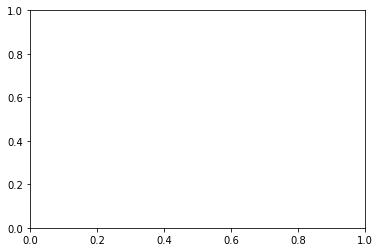

In [131]:
num_epochs=100
plt.plot(range(num_epochs), train_loss,'r', label="Train loss")
plt.plot(range(num_epochs), test_loss, 'bo',label="Test loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

##6. Model comparison


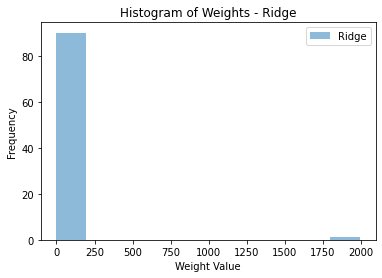

In [ ]:
# fig, ax = plt.subplots(figsize=(8, 6))
plt.hist(w_ridge, alpha=0.5, label='Ridge')
plt.xlabel('Weight Value')
plt.ylabel('Frequency')
plt.title('Histogram of Weights - Ridge')
plt.show()

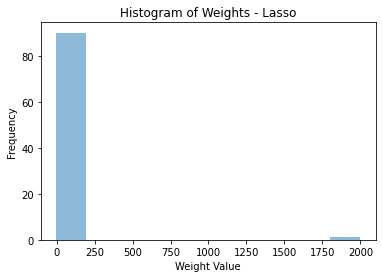

In [ ]:
plt.hist(w_lasso, alpha=0.5, label='Lasso')
plt.xlabel('Weight Value')
plt.ylabel('Frequency')
plt.title('Histogram of Weights - Lasso')
plt.show()

**Plot a histogram of the weights for the ridge, lasso, and count regression models. Discuss
how the weights differ**

For Ridge and Lasso regression, the weight is quite similar. It means that the penalty term applied is not really significant to the model.

Lasso regression gives significantly lower loss. It's important to note that Lasso is better at handling multicollinearity by performing feature selection and shrinking the cofficient towards zero and more effective in handling outliers. This might indicates our data has high sparsity or multicollinearity which resulting in Lasso performs better than Ridge.  However, since the weights are similar, it means that both Ridge and Lasso are able to capture relationships between the attributes and target varible.

**Discuss and compare the behaviors of the models. Are there certain periods (ranges of
years) in which models perform better than others? Where are the largest errors across
models. Did regularization help for some models but not others?**


In [34]:
#Evaluate model L2
periods = [(1920, 1940), (1940, 1960), (1960, 1980), (1980, 2000), (2000, 2020)]

for period in periods:
    train_mask = (train_y >= period[0]) & (train_y < period[1])
    test_mask = (test_y >= period[1]) & (test_y < period[1]+20)
    train_x_period, train_y_period = train_x[train_mask], train_y[train_mask]
    test_x_period, test_y_period = test_x[test_mask], test_y[test_mask]

    # Train the model using mini-batch gradient descent
    weight, train_losses, test_losses = mini_batch_gradient_descent(train_x_period, train_y_period, test_x_period, test_y_period, num_epochs=100, learning_rate=0.01, weight_decay_factor=0.001, loss_type='L2', weight_decay_form='L2')
    
    # Evaluate the performance of the model on the test set for the period
    y_pred = np.dot(test_x_period, weight)
    mse = np.mean(np.square(test_y_period - y_pred))
    print("Period:", period, "MSE:", mse)

ValueError: ignored

In [41]:
df.iloc[:, 0]

0         2001
1         2001
2         2001
3         2001
4         2001
          ... 
515340    2006
515341    2006
515342    2006
515343    2006
515344    2005
Name: target, Length: 515345, dtype: int64

In [32]:
#Evaluate L2
y_train_pred = np.dot(train_x, w_ridge)
train_rmse = np.sqrt(np.mean(np.square(train_y - y_train_pred)))
y_test_pred = np.dot(test_x, w_ridge)
test_rmse = np.sqrt(np.mean(np.square(test_y - y_test_pred)))
print("Train RMSE:", train_rmse)
print("Test RMSE:", test_rmse)

Train RMSE: 9.552927711558576
Test RMSE: 9.512634607284436


In [33]:
#Evaluate L1
y_train_pred = np.dot(train_x, w_lasso)
train_rmse = np.sqrt(np.mean(np.square(train_y - y_train_pred)))
y_test_pred = np.dot(test_x, w_lasso)
test_rmse = np.sqrt(np.mean(np.square(test_y - y_test_pred)))
print("Train RMSE:", train_rmse)
print("Test RMSE:", test_rmse)

Train RMSE: 9.870099705457289
Test RMSE: 9.791397438648032


From RMSE above, L1 Lasso Regression gives larger error compared to Ridge.

# Problem 5 - Softmax Properties


###1. Show that the softmax function is invariant to constant offsets to its input

\begin{align*}
softmax(a+c1) &= \frac{exp(a+c1)}{\sum_{j=1}^{n}exp(a_j+c)} \\
&= \frac{exp(a)exp(c1)}{\sum_{j=1}^{n}exp(a_j)exp(c)}\\
&= \frac{exp(a)}{\sum_{j=1}^{n}exp(a_j)} \times \frac{exp(c1)}{\sum_{j=1}^{n}exp(c)}{}\\
&= softmax(a) \times \frac{exp(c1)}{n \times exp(c)}{}\\
&= softmax(a) \times \frac{exp(c1-c)}{n}
\end{align*}

Since $\frac{exp(c1-c)}{n}$ is a constant, it doesn't depend on $a$ and it's proven that softmax function is invariant to constant offset to its input.


###2.  Why is the observation that the softmax function is invariant to constant offsets to its input important when implementing it in a neural network?

It's important that softmax function is invariant to constant offset to its input because it allows the model to be more robust to changes in input data. Adding or substracting a constant value from input data doesn't change the output of sofmax function and making the network to generalize better to new data that can improve reliability and accuracy.

# Problem 6 - Implementing Softmax Classifier

Write a function to load the data and the labels, which are returned as NumPy arrays.

In [47]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [57]:
from sklearn.model_selection import train_test_split

def load_iris_data(train_file, test_file):
    train_data = np.loadtxt(train_file)
    test_data = np.loadtxt(test_file)
    train_labels = train_data[:, 0].astype(int)
    train_features = train_data[:, 1:]
    test_labels = test_data[:, 0].astype(int)
    test_features = test_data[:, 1:]
    return train_features, train_labels, test_features, test_labels

iris_train = '/content/drive/MyDrive/Deep Learning/HW2/iris-train.txt'
iris_test = '/content/drive/MyDrive/Deep Learning/HW2/iris-test.txt'

train_features, train_labels, test_features, test_labels = load_iris_data(iris_train, iris_test)
X_train, X_test, y_train, y_test = train_test_split(train_features, train_labels, test_size=0.2, random_state=42)

print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(72, 2)
(18, 2)
(72,)
(18,)


##1. Implementation & Evaluation

* Use softmax loss with L2 weight decay regularization  
*  Use stochastic gradient descent with mini batches and momentum to minimize softmax loss of single LNN (use environment's BLAS)
* Loop over epochs and mini batches (not individual vector/ matrices)
* 1000 epochs
* Normalize feature between -1 and 1
* Initial weight from Gaussian distribution

*Cross entropy loss*

$y_{i,j}$: true label for the $i$-th sample and $j$-th class

$p_{i,j}$: predicted probability for the $i$-th sample and $j$-th class. 
$$ L = - \frac{1}{N} \sum_{i=1}^N \sum_{j=1}^C y_{i,j} \log(p_{i,j}) $$


What is the best test accuracy your model achieved? What hyperparameters did you use?
Would early stopping have helped improve accuracy on the test data?



In [68]:
#Normalize feature to be between -1 and 1
X_train= (X_train - np.mean(X_train, axis=0)) / (np.std(X_train, axis=0)+ 1e-8)
X_test= (X_test - np.mean(X_test, axis=0)) / (np.std(X_test, axis=0)+1e-8)

#Add bias to the features
X_train= np.hstack((np.ones((X_train.shape[0], 1)), X_train))
X_test= np.hstack((np.ones((X_test.shape[0], 1)), X_test))

def mini_batch_gradient_descent(train_x, train_y, test_x, test_y, num_epochs=1000, batch_size=32, learning_rate=0.01, momentum_rate=0.9, weight_decay_factor=0.01):
  num_classes = len(np.unique(train_y))
  W = np.random.normal(size=(train_x.shape[1], num_classes))
  v = np.zeros_like(W)

  def softmax(X):
    exp_X = np.exp(X)
    return exp_X / np.sum(exp_X, axis=1, keepdims=True)
  
  def cross_entropy_loss(y_true, y_pred, W):
    num_samples = y_true.shape[0]
    data_loss = -np.sum(np.log(y_pred[range(num_samples), y_true]))
    reg_loss = 0.5 * weight_decay_factor * np.sum(W**2)
    return (data_loss + reg_loss) / num_samples
  
  # Define the function to compute the gradients of the loss with respect to the weights
  def compute_gradients(X, y_true, y_pred, W):
      num_samples = y_true.shape[0]
      grad_data_loss = y_pred
      grad_data_loss[range(num_samples), y_true] -= 1
      grad_data_loss /= num_samples
      grad_W = np.dot(X.T, grad_data_loss) + weight_decay_factor * W
      return grad_W
  
  train_losses = []
  test_losses = []
  train_accs = []
  test_accs = []

  # Loop over the epochs
  for epoch in range(num_epochs):
    # Shuffle the data
    perm = np.random.permutation(train_X.shape[0])
    train_X = train_X[perm]
    train_y = train_y[perm]

    # Loop over the batches
    for i in range(0, train_X.shape[0], batch_size):
        batch_X = train_X[i:i+batch_size]
        batch_y = train_y[i:i+batch_size]
        batch_pred = softmax(np.dot(batch_X, W)) #Compute y_predict
        grad_W = compute_gradients(batch_X, batch_y, batch_pred, W) #Compute gradient

        # Update weights with momentum
        v = momentum_rate * v - learning_rate * grad_W
        W += v

    # Compute the predictions and losses
    train_pred = softmax(np.dot(train_x, W))
    train_loss = cross_entropy_loss(train_y, train_pred, W)
    train_losses.append(train_loss)
    train_acc = np.mean(train_y == np.argmax(train_pred, axis=1))
    train_accs.append(train_acc)
    test_pred = softmax(np.dot(test_x, W))
    test_loss = cross_entropy_loss(test_y, test_pred, W)
    test_losses.append(test_loss)
    test_acc = np.mean(test_y == np.argmax(test_pred, axis=1))
    test_accs.append(test_acc)
  
  return train_losses, train_accs, test_losses, test_accs


In [70]:
train_losses, train_accuracies, test_losses, test_accuracies= mini_batch_gradient_descent(X_train, y_train, X_test, y_test, num_epochs=1000, batch_size=32, learning_rate=0.01, momentum_rate=0.9, weight_decay_factor=0.01)

UnboundLocalError: ignored

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

# Plot the cross-entropy loss during training for both the train and test sets
ax1.plot(range(num_epochs), train_losses, label='Train')
ax1.plot(range(num_epochs), test_losses, label='Test')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Cross-entropy loss')
ax1.set_title('Training and test loss')
ax1.legend()

# Plot the accuracy during training for both the train and test sets
ax2.plot(range(num_epochs), train_accuracies, label='Train')
ax2.plot(range(num_epochs), test_accuracies, label='Test')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Mean per-class accuracy')
ax2.set_title('Training and test accuracy')
ax2.legend()

# Show the figure
plt.show()